<a href="https://www.kaggle.com/code/jaimemorillo/profile-based-retrieval?scriptVersionId=92197130" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, LabelEncoder

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
tqdm.pandas()

# Data

Read the dataset

In [2]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
print('Shape: ' + str(df.shape))
display(df.head(5))

Shape: (200853, 6)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Select 5 topics ('POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'SPORTS') and headline column

In [3]:
column_selected = 'headline' # choose short_description or headline
classes = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'SPORTS']

df = df[[column_selected, 'category']]
df = df[df['category'].isin(classes)]
print('New shape: ' + str(df.shape))
display(df.head(5))

New shape: (81395, 2)


,headline,category
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT
5,Morgan Freeman 'Devastated' That Sexual Harass...,ENTERTAINMENT


### Labels

Distribution of labels

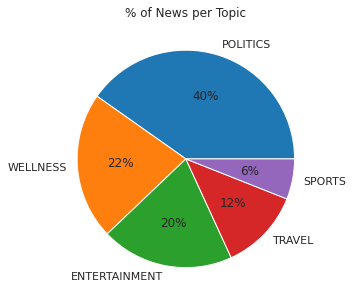

In [4]:
plot = df.category.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                         figsize=(5, 5), 
                                                         title='% of News per Topic', 
                                                         ylabel='')

Encode labels (ENTERTAINMENT -> 0, POLITICS -> 1, SPORTS -> 2, TRAVEL -> 3, WELLNESS -> 4)

In [5]:
le = LabelEncoder()
df['category'] = le.fit_transform(df.category)
classes = list(le.classes_)
print(classes)

['ENTERTAINMENT', 'POLITICS', 'SPORTS', 'TRAVEL', 'WELLNESS']


### Word Count

Descriptive table of the number of words

In [6]:
word_lens = df[column_selected].str.split(" ").str.len()
display(word_lens.describe().round(2))

count    81395.00
mean         9.59
std          3.12
min          1.00
25%          7.00
50%         10.00
75%         12.00
max         44.00
Name: headline, dtype: float64

Histogram

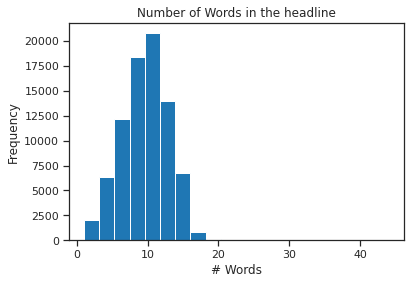

In [7]:
ax = word_lens.plot.hist(bins=20, title='Number of Words in the ' + column_selected)
plot = ax.set_xlabel("# Words")

# Preprocessing
- Lower-case text.
- Replacing contractions.
- Cleaning up special characters.
- Removing extra whitespaces.
- Removing stopwords.
- Lemmatize.

In [8]:
class Normalizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.ps = PorterStemmer() # Create Stemmer
        self.word_net = WordNetLemmatizer() #Create Lemmatizer
    
    def remove_punct(self, text):
        text = text.lower() # To lower case
        # Replace contractions
        text = re.sub(r"\'s", " is ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub('\W', ' ', text) # Replace any character which is not a word character
        text = re.sub('\s+', ' ', text) # Replace any whitespace character
        text = re.sub(' +', ' ', text) # Replace multiple whitespaces
        text = text.strip() # Delete sorrounding whitespaces
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stop_words(self, tokens):
        return [word for word in tokens if not word in self.stop_words] 
    
    def stemming(self, tokens):
        return [ps.stem(word) for word in tokens]
    
    def lemmatize(self, tokens):
        return [self.word_net.lemmatize(word) for word in tokens]
    
    def return_sentences(self, tokens):
        return " ".join(tokens)
    
    def clean_all(self, text):
        text = self.remove_punct(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stop_words(tokens)
        tokens = self.lemmatize(tokens)
        text = self.return_sentences(tokens)
        return text

Create a copy of the dataset to retain original headlines

In [9]:
df_final = df.copy()

Apply the normalizer to all the headlines

In [10]:
norm = Normalizer()
df_final[column_selected] = df_final[column_selected].progress_apply(lambda x: norm.clean_all(x))

  0%|          | 0/81395 [00:00<?, ?it/s]

Example

In [11]:
print('Original: ' + df[column_selected].iloc[50])
print('New: ' + df_final[column_selected].iloc[50])

Original: Trump Abruptly Cancels North Korea Summit With Kim Jong Un
New: trump abruptly cancel north korea summit kim jong un


In [12]:
display(df_final.head(5))

,headline,category
1,smith join diplo nicky jam 2018 world cup offi...,0
2,hugh grant marries first time age 57,0
3,jim carrey blast castrato adam schiff democrat...,0
4,julianna margulies us donald trump poop bag pi...,0
5,morgan freeman would evastated sexual harassme...,0


## Split Train and Test
Train (80%) and Test (20%). Stratified to maintain the proportion of the labels

In [13]:
X = df_final[column_selected]
y = df_final.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
print('Shape train: ' + str(X_train.shape))
print('Shape test: ' + str(X_test.shape))

Shape train: (65116,)
Shape test: (16279,)


# Encoding

## Text encoding - TF-IDF

Apply Tf-Idf strategy to encode the text

Ignore words that appear in less than 10 document and more than 80% of the documents

In [14]:
tfidf = TfidfVectorizer(max_df=0.8, min_df=10, use_idf=True, smooth_idf=True, sublinear_tf=True)
X_train_enc = tfidf.fit_transform(X_train)
X_test_enc = tfidf.transform(X_test)

print('Size of the Vocabulary: ' + str(X_train_enc.shape[1]))
print('Original: ' + X_train.iloc[0])
print('Encoded: ' + str(X_train_enc[0]))

Size of the Vocabulary: 5910
Original: mueller threatened subpoena trump lawyer refused sit interview
Encoded:   (0, 2751)	0.2995407895110241
  (0, 4861)	0.39155313933126545
  (0, 4349)	0.4206528832271136
  (0, 3046)	0.31529782035377196
  (0, 5511)	0.14287966496142335
  (0, 5132)	0.4206528832271136
  (0, 5358)	0.40562213941864717
  (0, 3537)	0.344539002144151


## Users encoding

Use Users class to generate and encode the users as a dictionary

In [15]:
class Users:
    # Receives a number of users and classes (interests)
    def __init__(self, n_users, classes):
        self.users = self.create_users(n_users, classes)
        
    def create_users(self, n_users, classes):
        users = [('user_' + str(i), random.sample(classes, 
                                                  random.randint(1,4))) for i in range(1, n_users + 1)]
        return dict(users)
    
    def get_preferences(self, user_name):
        return self.users[user_name]
    
    def get_users_names(self):
        return list(self.users.keys())
    
    def get_items(self):
        return self.users.items()

Generate random users

In [16]:
users = Users(5, classes)
display(users.users)

{'user_1': ['POLITICS'],
 'user_2': ['WELLNESS', 'POLITICS'],
 'user_3': ['ENTERTAINMENT', 'POLITICS', 'WELLNESS'],
 'user_4': ['ENTERTAINMENT', 'WELLNESS', 'SPORTS', 'POLITICS'],
 'user_5': ['TRAVEL', 'ENTERTAINMENT', 'WELLNESS', 'SPORTS']}

# Modelling

Train 2 different models

## LinearSVC

Train LinearSVC using gridsearch, stratified cross-validation and optimizing the balanced accuracy

In [17]:
param_grid = { 
    'penalty': ['l1', 'l2'],
    'loss' : ['hinge', 'squared_hinge'],
    'C': np.arange(0.1, 1.1, 0.1),
    'class_weight': ['balanced']
}

svc = LinearSVC(random_state=9)
svc_clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, # Stratified Kfold by default (cv)
                       scoring='balanced_accuracy', refit=True,
                       return_train_score=False, n_jobs=-1, verbose=1)
svc_clf.fit(X_train_enc, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/opt/co

GridSearchCV(cv=5, estimator=LinearSVC(random_state=9), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced'],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='balanced_accuracy', verbose=1)

In [18]:
display(pd.DataFrame(svc_clf.cv_results_).sort_values('rank_test_score').head(5))
print('Best score: ' + str(svc_clf.best_score_))
print('Best params: ' + str(svc_clf.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,1.102447,0.027453,0.006756,0.000404,0.3,balanced,squared_hinge,l2,"{'C': 0.30000000000000004, 'class_weight': 'ba...",0.856989,0.854426,0.856773,0.855288,0.855769,0.855849,0.000949,1
7,0.929975,0.017349,0.006873,0.000459,0.2,balanced,squared_hinge,l2,"{'C': 0.2, 'class_weight': 'balanced', 'loss':...",0.857028,0.855577,0.856930,0.854736,0.854703,0.855795,0.001017,2
21,2.312394,0.169099,0.006715,0.000503,0.6,balanced,hinge,l2,"{'C': 0.6, 'class_weight': 'balanced', 'loss':...",0.857163,0.854450,0.855239,0.855664,0.854547,0.855413,0.000983,3
33,2.746371,0.247229,0.006507,0.000109,0.9,balanced,hinge,l2,"{'C': 0.9, 'class_weight': 'balanced', 'loss':...",0.858854,0.854604,0.854129,0.854035,0.855227,0.855370,0.001793,4
29,2.671659,0.153447,0.006502,0.000295,0.8,balanced,hinge,l2,"{'C': 0.8, 'class_weight': 'balanced', 'loss':...",0.858201,0.854604,0.852989,0.855553,0.854429,0.855155,0.001729,5


Best score: 0.8558489996828632
Best params: {'C': 0.30000000000000004, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}


## Naive Bayes

In [19]:
param_grid = { 
    'alpha': np.arange(0, 1.1, 0.1),
    'fit_prior': [True, False],
}

svc = MultinomialNB()
nb_clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, # Stratified Kfold by default (cv)
                      scoring='balanced_accuracy', refit=True,
                      return_train_score=False, n_jobs=-1, verbose=1)
nb_clf.fit(X_train_enc, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'fit_prior': [True, False]},
             scoring='balanced_accuracy', verbose=1)

In [20]:
display(pd.DataFrame(nb_clf.cv_results_).sort_values('rank_test_score').head(5))
print('Best score: ' + str(nb_clf.best_score_))
print('Best params: ' + str(nb_clf.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.028115,0.004006,0.006118,0.000324,0.4,False,"{'alpha': 0.4, 'fit_prior': False}",0.848199,0.841636,0.844795,0.846691,0.845506,0.845365,0.002193,1
11,0.026582,0.000545,0.006241,0.000235,0.5,False,"{'alpha': 0.5, 'fit_prior': False}",0.847387,0.842266,0.845334,0.846505,0.845094,0.845317,0.001735,2
13,0.028409,0.002031,0.006348,0.000159,0.6,False,"{'alpha': 0.6000000000000001, 'fit_prior': False}",0.846469,0.842300,0.845673,0.846643,0.844245,0.845066,0.001622,3
15,0.026869,0.001274,0.006133,0.000178,0.7,False,"{'alpha': 0.7000000000000001, 'fit_prior': False}",0.845894,0.842214,0.844958,0.845852,0.844581,0.844700,0.001343,4
7,0.029252,0.004256,0.006289,0.000116,0.3,False,"{'alpha': 0.30000000000000004, 'fit_prior': Fa...",0.847540,0.840664,0.843935,0.845566,0.844628,0.844467,0.002255,5


Best score: 0.845365331468597
Best params: {'alpha': 0.4, 'fit_prior': False}


# Results

Create the functions to obtain the metrics:
- Accuracy, Balanced accuracy and Report
- Confusion matrix
- Roc curve

In [21]:
def general_metrics(y_test, y_pred):
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred).round(2)))
    print('Balanced Accuracy: ' + str(balanced_accuracy_score(y_test, y_pred).round(2)))
    print('Report:')
    print(classification_report(y_test, y_pred))

def plot_confusion_matrix(y_test, y_pred, classes):
    fig, ax = plt.subplots(figsize=(10, 8))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=classes)
    cmp.plot(ax=ax)
    plt.show()
    
def plot_roc_curve(y_test, y_pred, classes):
    n_classes = len(classes)
    y_test = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
  
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,5))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
             color="tab:pink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
             label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
             color="tab:gray", linestyle=":", linewidth=4,)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    for i, color in enumerate(colors):
        type_class = classes[i]
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                 label="ROC curve of " + type_class +" (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()

## LinearSVC Results

In [22]:
y_pred = svc_clf.predict(X_test_enc)

general_metrics(y_test, y_pred)

Accuracy: 0.88
Balanced Accuracy: 0.86
Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3212
           1       0.94      0.91      0.92      6548
           2       0.76      0.79      0.77       977
           3       0.83      0.86      0.84      1977
           4       0.84      0.88      0.86      3565

    accuracy                           0.88     16279
   macro avg       0.85      0.86      0.85     16279
weighted avg       0.88      0.88      0.88     16279



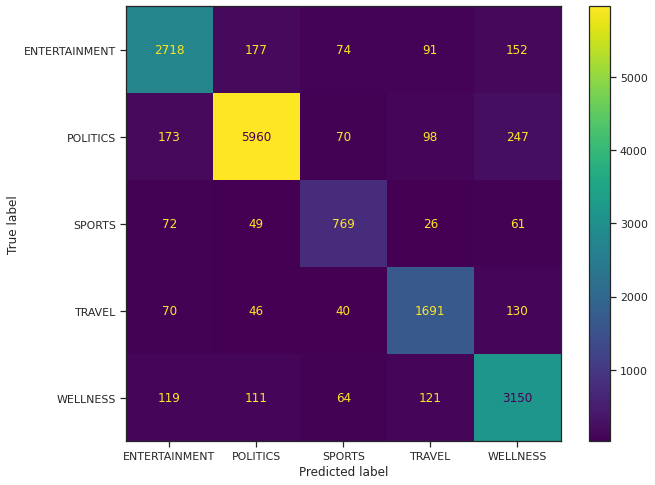

In [23]:
plot_confusion_matrix(y_test, y_pred, classes)

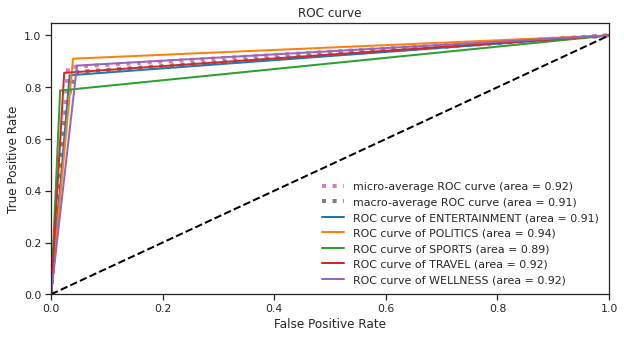

In [24]:
plot_roc_curve(y_test, y_pred, classes)

## Naive Bayes Results

In [25]:
y_pred = nb_clf.predict(X_test_enc)

general_metrics(y_test, y_pred)

Accuracy: 0.85
Balanced Accuracy: 0.85
Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3212
           1       0.94      0.88      0.91      6548
           2       0.62      0.83      0.71       977
           3       0.77      0.86      0.82      1977
           4       0.87      0.82      0.85      3565

    accuracy                           0.85     16279
   macro avg       0.81      0.85      0.82     16279
weighted avg       0.86      0.85      0.86     16279



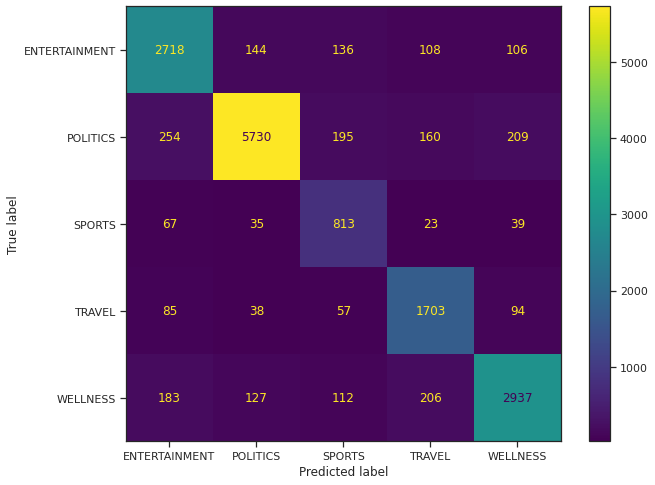

In [26]:
plot_confusion_matrix(y_test, y_pred, classes)

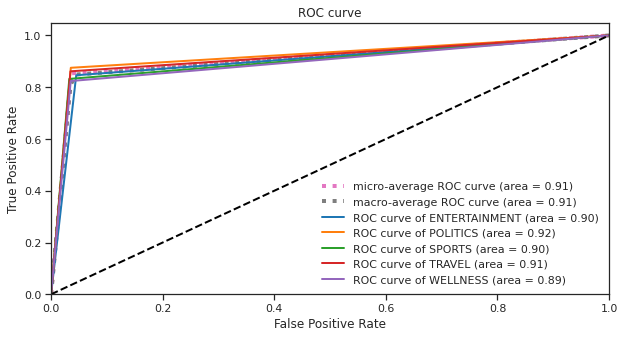

In [27]:
plot_roc_curve(y_test, y_pred, classes)

# Demo

In [28]:
def get_random_new(news_df, classes, topic):
    sample = news_df[test_og['category'] == classes.index(topic)].sample(1).iloc[0]
    text = sample['headline']
    label = sample['category']
    return text, label

def deliver_new(new, normalizer, encoder, model, users, classes):
    print('Headline: ' + new[0])
    #print('True label: ' + classes[new[1]])
    
    new = new[0]
    new_norm = normalizer.clean_all(new)
    new_enc = encoder.transform([new_norm])
    idx_class = model.predict(new_enc)[0]
    class_ = classes[idx_class]
    
    print('Classify as: ' + class_)
    print('Delivered to the following users: ', end='')
    final_users = []
    for k,v in users.get_items():
        if class_ in v:
            final_users.append(k)
    print(final_users)

In [29]:
users = Users(10, classes)
users.users

{'user_1': ['WELLNESS', 'POLITICS', 'TRAVEL', 'SPORTS'],
 'user_2': ['ENTERTAINMENT', 'POLITICS'],
 'user_3': ['WELLNESS', 'SPORTS'],
 'user_4': ['POLITICS', 'TRAVEL', 'ENTERTAINMENT'],
 'user_5': ['POLITICS'],
 'user_6': ['WELLNESS', 'POLITICS'],
 'user_7': ['ENTERTAINMENT', 'SPORTS', 'WELLNESS'],
 'user_8': ['SPORTS', 'POLITICS'],
 'user_9': ['WELLNESS', 'SPORTS', 'ENTERTAINMENT'],
 'user_10': ['TRAVEL', 'POLITICS']}

Retrieve the original test set headlines

In [30]:
test_og = df.loc[y_test.index]

Example by distributing a random ENTERTAINMENT news item

In [31]:
new = get_random_new(test_og, classes, 'ENTERTAINMENT')
deliver_new(new, norm, tfidf, nb_clf, users, classes)

Headline: The Unexpected Wisdom Of Kevin McCallister
Classify as: WELLNESS
Delivered to the following users: ['user_1', 'user_3', 'user_6', 'user_7', 'user_9']
